# NLP on the Teacher Educator Survey
Goals: <br/>
- What are people talking about?
    - Topic model
- Are there any differences between comments by teachers and admin?
- What is the overall sentiment of the comments?
    - Does it differ by topic?
- Is there a correlation with other survey answers?

## Preliminary Findings

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings(action='once')

## Importing Survey Data

In [3]:
clean_survey_data = pd.read_stata('N:/Research and Policy/ORP_Data/Surveys/TES/Cleaned_Files/2018/2018TNEdSurveyResultsFile_7.7.18_NoDeIdentTchNum_Weights.dta')


In [4]:
list(clean_survey_data.columns)[:10]

['tchlic',
 'Email',
 'sch_id',
 'district_no',
 'school_no',
 'district_name',
 'school_name',
 'LastName',
 'FirstName',
 'MiddleName']

## Selecting Columns to keep

In [5]:
cols_to_keep = ['tchlic', 'district_no', 'district_name', 'school_no', 'school_name','Gender', 'YrsExpr18', 'EdLevel18', 
                'Role_Compass', 'bestguess_tch', 'bestguess_admin', 'IPI_Sch', 'Tier_Sch', 'StartTime', 
                'EndTime', 'Responded', 'Q13', 'TC_01d','TC_02c', 'TC_16b']

In [6]:
df_selected_columns = clean_survey_data.loc[:,cols_to_keep]

In [7]:
df_selected_columns.shape

(71636, 20)

## 71,636 surveys

### But how many answered the open ended question (Q13)

Negative Nancies
- Are they more likely to leave a comment if they answer the following questions negatively

    -	TC01d: The staff at this school like being here; I would describe us as a satisfied group. 
        - 1: strongly agree, 2: Disagree, 3: Agree, 4: Strongly Agree
    -	TC02c: I like the way things are run at this school.
        - 1: strongly agree, 2: Disagree, 3: Agree, 4: Strongly Agree
    -	TC16b: In general, the teacher evaluation process used in my school has led to improvements in my teaching. 
        - 1: strongly agree, 2: Disagree, 3: Agree, 4: Strongly Agree


In [8]:
df_selected_columns.TC_01d.value_counts()

3.0    18091
4.0    10970
2.0     5362
1.0     1510
Name: TC_01d, dtype: int64

In [9]:
df_selected_columns.TC_02c.value_counts()

3.0    17041
4.0    10294
2.0     6320
1.0     2117
Name: TC_02c, dtype: int64

In [10]:
df_selected_columns.TC_16b.value_counts()

3.0    19847
2.0     7376
4.0     6151
1.0     2037
Name: TC_16b, dtype: int64

## How many people answered Q13

In [11]:
# Many ways in which people say no
df_selected_columns.Q13.value_counts().head(15)

                      56969
no                      461
No                      376
N/A                     201
n/a                     118
none                     64
None                     63
Not at this time.        62
No.                      59
NA                       57
na                       41
Not at this time         37
.                        29
None at this time.       24
not at this time         23
Name: Q13, dtype: int64

## Remove the ways in which people say no

In [12]:
# Remove blank or answers which signify no answer
def label_q13 (row):
    ans_str = row['Q13']
#     if 'at this time' in ans_str:
#         print(ans_str)
#         return 0
    if len(row['Q13']) > 23 : # Only keep over 23 characters
          return 1
    return 0

def length_response (row):
    return len(row['Q13'])

df_selected_columns['answered_q13'] = df_selected_columns.apply(label_q13, axis=1)
df_selected_columns['total_surveys_sent'] = df_selected_columns.shape[0]
df_selected_columns['total_number_responses'] = df_selected_columns.Responded.sum()
df_selected_columns['total_answered_q13'] = df_selected_columns.answered_q13.sum()
df_selected_columns['response_character_length'] = df_selected_columns.apply(length_response, axis = 1)

In [13]:
df_selected_columns.head()

,tchlic,district_no,district_name,school_no,school_name,Gender,YrsExpr18,EdLevel18,Role_Compass,bestguess_tch,...,Responded,Q13,TC_01d,TC_02c,TC_16b,answered_q13,total_surveys_sent,total_number_responses,total_answered_q13,response_character_length
0,17364,130,Claiborne County,35,Clairfield Elementary,M,31.0,MA+,Principal,0,...,1,No,NaN,NaN,NaN,0,71636,40876,12640,2
1,17522,600,Maury County,30,Culleoka Unit School,F,NaN,MA+,,1,...,0,,NaN,NaN,NaN,0,71636,40876,12640,0
2,18016,900,Washington County,115,Tennessee Virtual Learning Academy,F,NaN,MA+,,1,...,1,,4.0,4.0,3.0,0,71636,40876,12640,0
3,20735,850,Trousdale County,15,Jim Satterfield Middle School,F,46.0,MA,Teacher,1,...,1,,3.0,4.0,NaN,0,71636,40876,12640,0
4,32910,830,Sumner County,120,Westmoreland High School,F,54.0,MA+,Teacher,1,...,0,,NaN,NaN,NaN,0,71636,40876,12640,0


In [14]:
df_selected_columns.loc[df_selected_columns['answered_q13'] == 1,:].Q13.value_counts().head(20)

This survey is too long.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [15]:
print('Number of teachers surveyed: ' + str(sum(df_selected_columns['bestguess_tch'])))
print('Number of teachers responded: ' + str(sum(df_selected_columns.loc[(df_selected_columns.loc[:,'Responded'] == 1) & (df_selected_columns.loc[:,'bestguess_tch'] == 1), 'Responded'])))
print('Number of teachers answered Question 13: ' + str(sum(df_selected_columns.loc[(df_selected_columns.loc[:,'answered_q13'] == 1) & (df_selected_columns.loc[:,'bestguess_tch'] == 1), 'answered_q13'])))


Number of teachers surveyed: 67483
Number of teachers responded: 38665
Number of teachers answered Question 13: 12095


In [16]:
print('Number of admins surveyed: ' + str(sum(df_selected_columns['bestguess_admin'])))
print('Number of admins responded: ' + str(sum(df_selected_columns.loc[(df_selected_columns.loc[:,'Responded'] == 1) & (df_selected_columns.loc[:,'bestguess_admin'] == 1), 'Responded'])))
print('Number of admins answered Question 13: ' + str(sum(df_selected_columns.loc[(df_selected_columns.loc[:,'answered_q13'] == 1) & (df_selected_columns.loc[:,'bestguess_admin'] == 1), 'answered_q13'])))


Number of admins surveyed: 3113
Number of admins responded: 1791
Number of admins answered Question 13: 496


In [17]:
df_selected_columns.loc[df_selected_columns['answered_q13'] == 1,:].Q13.value_counts()

This survey is too long.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Seeing if people who answer those questions negatively are more likely to leave a comment

In [18]:
df_selected_columns.loc[df_selected_columns['Responded'] == 1,:]\
            [['tchlic', 'answered_q13', 'TC_01d','TC_02c', 'TC_16b']].groupby(['answered_q13'])\
            .agg({'tchlic':'size', 'TC_01d': ['mean'], 'TC_02c': ['mean'], 'TC_16b': ['mean']})\
            .rename(columns={'tchlic':'count', 'TC_01d':'TC_01d_mean', 'TC_02c':'TC_02c_mean', 'TC_16b':'TC_16b_mean'})

,count,TC_01d_mean,TC_02c_mean,TC_16b_mean
,size,mean,mean,mean
answered_q13,,,,
0,28236,3.116550,3.053082,2.932639
1,12640,2.974632,2.860757,2.672791


In [19]:
df_responded = df_selected_columns.loc[df_selected_columns.loc[:,'Responded'] == 1,:]

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


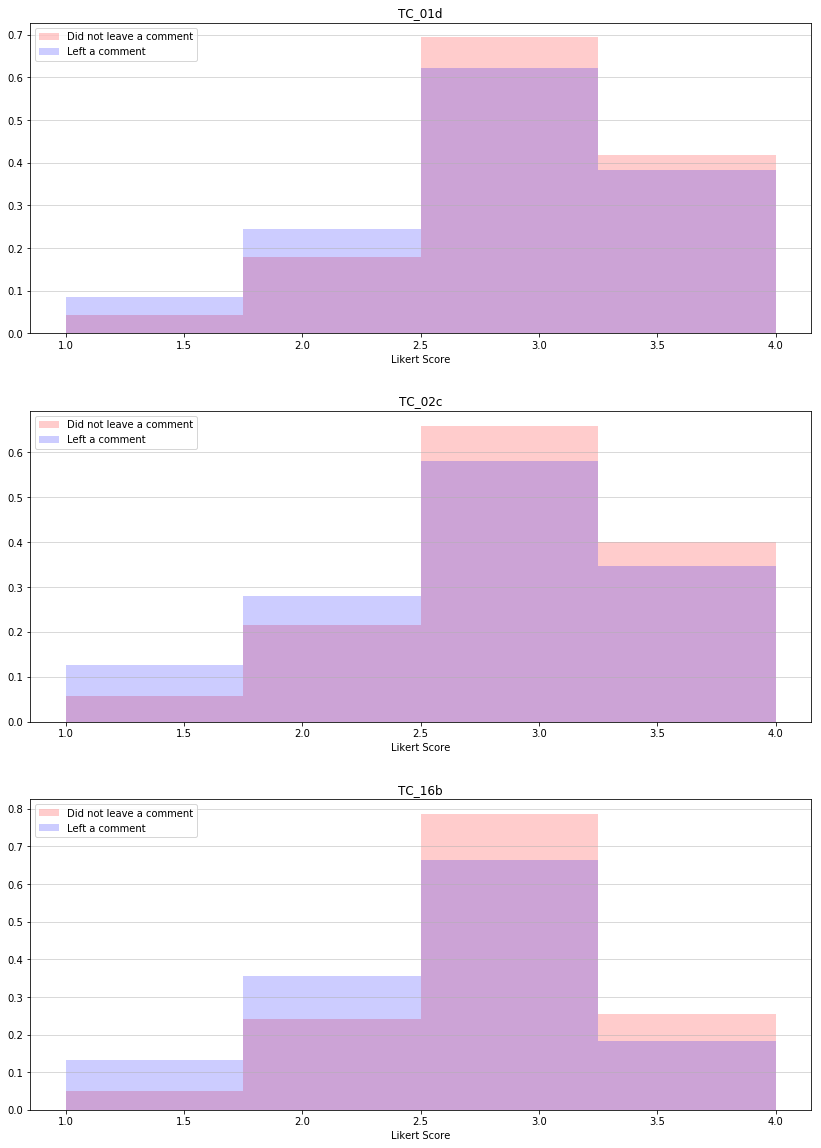

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(14,20))
bins = 4
row = 0
for quest in ['TC_01d','TC_02c', 'TC_16b']:
    x = df_responded.loc[(df_responded['answered_q13'] == 0), quest].values
    #print(type(x))
    y = df_responded.loc[(df_responded['answered_q13'] == 1), quest].values
    axes[row].set_title(quest)
    axes[row].set_xlabel('Likert Score')
    axes[row].hist(x, bins, alpha=0.2, label='Did not leave a comment', density = True, color = 'red')
    axes[row].hist(y, bins, alpha=0.2, label='Left a comment', density = True, color = 'blue')
    axes[row].legend(loc="upper left")
    axes[row].grid(axis = 'y', alpha = 0.6)
    plt.subplots_adjust(hspace=.25)
    row+=1
    

## Creating list of comments

In [21]:
# Converting the column of the DF with answers into a list of answers
open_ended_answers = df_selected_columns.loc[df_selected_columns['answered_q13'] == 1,:].Q13.tolist()

In [22]:
open_ended_answers[:5]

['Each year there seems to be more added to the teachers plate, making it more difficult to focus on teaching.  Teachers seem to be more stressed than ever before.  The constant changing of testing and evaluations have certainly contributed to this stress.  The state testing seems to be unfair in many ways.  Some teachers have never taught a tested subject and have not had the stress that the tested teachers have.  At the same time, their evaluations are determined, in part, by the success or lack of success of other teachers which is unfair to them.  Some tested subjects are scheduled for a full year, allowing sufficient time to cover all of the state standards while other teachers of tested subjects have only a semester to teach a similar set of standards.',
 'Give TCAP test in all grades. Give pre- and post in k. Give post in every other grade. This would give a more accurate growth score for all teachers. If growth scores are important then give teachers their OWN SCORES. Giving te

In [23]:
# Join all answers into one string
joined_answers = ' '.join(open_ended_answers)

# Words per comment


In [27]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [28]:
open_ended_answers_any_length = df_selected_columns.loc[df_selected_columns['response_character_length'] >= 1,:].Q13.tolist()

In [29]:
words_list = [word_tokenize(comment) for comment in open_ended_answers_any_length]
words_list_no_punct = [[token for token in token_list if token.isalpha()] for token_list in words_list]
comment_word_counts = [len(word_list) for word_list in words_list_no_punct]

In [34]:
round(np.mean(comment_word_counts),0)

72.0

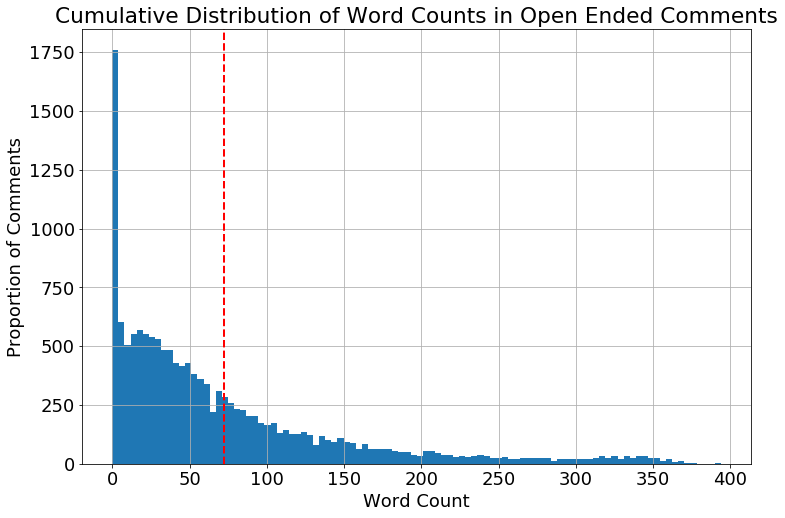

In [48]:
f, ax = plt.subplots()
ax.hist(comment_word_counts, bins = 100)
# ax.axvline(20, color='yellow', linestyle='dashed', linewidth=2)
ax.axvline(round(np.mean(comment_word_counts), 0), color='red', linestyle='dashed', linewidth=2)
# ax.axhline(0.5, color='red', linestyle='dashed', linewidth=2)
ax.grid()
# plt.xticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,34,360,380])
ax.set_xlabel('Word Count')
ax.set_ylabel('Proportion of Comments')
ax.set_title('Cumulative Distribution of Word Counts in Open Ended Comments');

# Sentences per comment

In [36]:
sent_list = [sent_tokenize(comment) for comment in open_ended_answers_any_length]

In [41]:
comment_sent_counts = [len(sents) for sents in sent_list if len(sents) != 73]

In [42]:
max(comment_sent_counts)

36

In [43]:
round(np.mean(comment_sent_counts), 2)

4.48

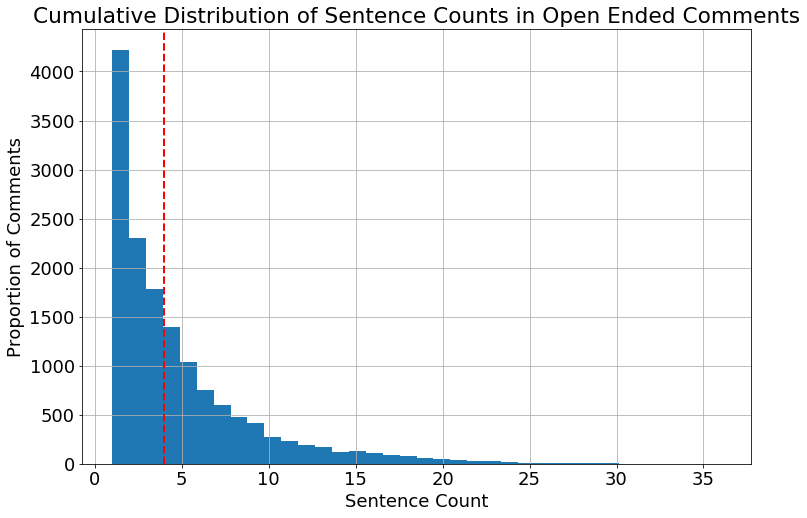

In [49]:
f, ax = plt.subplots()
ax.hist(comment_sent_counts, bins = 36)
# ax.axvline(20, color='red', linestyle='dashed', linewidth=2)
ax.axvline(round(np.mean(comment_sent_counts), 0), color='red', linestyle='dashed', linewidth=2)
# ax.axhline(0.5, color='red', linestyle='dashed', linewidth=2)
ax.grid()
# plt.xticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,34,360,380])
ax.set_xlabel('Sentence Count')
ax.set_ylabel('Proportion of Comments')
ax.set_title('Cumulative Distribution of Sentence Counts in Open Ended Comments');

## Most common words
- NLTK Tokenization

In [23]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C

In [24]:
# Turn string into lowercase
# Then tokenize into words
tokens = [w for w in word_tokenize(joined_answers.lower()) if w.isalpha()]

In [25]:
# for each word, check if it is in the list of English stop words
# Only keep the words that are not in the list of stopwords
no_stops = [t for t in tokens
           if t not in stopwords.words('english')]

In [26]:
# Initiate Word Net Lemmatizer
# Will create lemmas (word bases)
wnl = nltk.WordNetLemmatizer()

In [27]:
# For each word in no_stops list, lemmatize
lemmas =  [wnl.lemmatize(t) for t in no_stops]

In [28]:
# Counter object 
Counter(lemmas).most_common(35)

[('student', 16246),
 ('teacher', 14896),
 ('school', 10301),
 ('time', 7967),
 ('need', 6604),
 ('year', 5880),
 ('test', 5421),
 ('state', 4544),
 ('testing', 4239),
 ('feel', 3598),
 ('would', 3507),
 ('standard', 3314),
 ('teaching', 3050),
 ('teach', 2921),
 ('many', 2916),
 ('much', 2912),
 ('like', 2778),
 ('work', 2720),
 ('classroom', 2582),
 ('one', 2574),
 ('grade', 2565),
 ('score', 2525),
 ('level', 2461),
 ('education', 2458),
 ('also', 2397),
 ('get', 2281),
 ('day', 2255),
 ('evaluation', 2235),
 ('district', 2209),
 ('way', 2205),
 ('child', 2071),
 ('make', 2023),
 ('u', 1981),
 ('take', 1911),
 ('know', 1824)]

## Topic Modeling

In [29]:
# Importing the relevant libraries
import gensim
from gensim import corpora
from pprint import pprint
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [30]:
# Loading relevant libraries
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
import re
import pyLDAvis.gensim
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
# logging.root.setLevel(level=logging.INFO)
stop_words = stopwords.words('english')
stop_words = stop_words + ['com', 'edu', 'would', 'could', 'also', 'le', 'thank_you', 'u', 'etc']

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [31]:
def make_trigrams_mod(texts, trigram_model, bigram_model):
    return [trigram_model[bigram_model[doc]] for doc in texts]

In [32]:
# Outputs list of lists with trigrams for each answer in a list
def preprocess_responses(text_list, bigram_min_count = 3, bigram_threshold = 8, trigram_min_count = 2, trigram_threshold = 8):
    # Make all words lowercase and remove punctuation
    lower_no_punctuation = [[text for text in word_tokenize(doc.lower()) if text.isalpha()] for doc in text_list]
    # Establish stop words
    # Needs stopwords from nltk.corpus
    stop_words = stopwords.words('english')
    stop_words = stop_words + ['would', 'could', 'also', 'le', 'thank_you', 'u', 'etc', 't',
                              'the', 'and', 'are', 'of', 'for', 'that']
    # remove stop words
    text_no_stops = [[text for text in doc if text not in stop_words] for doc in lower_no_punctuation]
    # Lemmatize
    text_lemmatized = [[wnl.lemmatize(text) for text in doc] for doc in text_no_stops]
    # models for trigrams and bigrams
    bigram_topics = Phrases(text_lemmatized, min_count = bigram_min_count, threshold = bigram_threshold)
    trigram_topics = Phrases(bigram_topics[text_lemmatized], min_count = trigram_min_count, threshold = trigram_threshold)
    # Phraser for better performance
    bigram_mod = Phraser(bigram_topics)
    trigram_mod = Phraser(trigram_topics)
    # Make trigrams (also forms bigrams in the process)
    topic_trigrams = make_trigrams_mod(text_lemmatized, trigram_mod, bigram_mod)
    return topic_trigrams
    

In [33]:
def make_lda_topic_model(preprocessed_list, num_topics = 10, chunksize = 200, passes = 10):
    # create dictionary
    id2word = corpora.Dictionary(preprocessed_list)
    # Create Corpus
    texts = preprocessed_list
    corpus = [id2word.doc2bow(text) for text in texts] # Term Document Frequency
    # Created model with gensim LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)
    return id2word, corpus, lda_model

In [34]:
def make_topic_visual(model, corpus, dictionary):
    lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
    return pyLDAvis.display(lda_display)

In [35]:
answers = preprocess_responses(open_ended_answers, 
                               bigram_min_count = 3, bigram_threshold = 8, 
                               trigram_min_count = 2, trigram_threshold = 3)

In [36]:
dictionary, corpus, lda_model = make_lda_topic_model(answers)

In [37]:
# Words composing topics with 10 topics created
pprint(lda_model.print_topics())

[(0,
  '0.038*"child" + 0.030*"education" + 0.029*"feel_like" + 0.020*"issue" + '
  '0.015*"plan" + 0.015*"back" + 0.013*"idea" + 0.012*"others" + '
  '0.011*"everything" + 0.010*"sometimes"'),
 (1,
  '0.027*"portfolio" + 0.020*"process" + 0.019*"planning" + 0.018*"wish" + '
  '0.017*"every" + 0.016*"lesson" + 0.013*"admin" + 0.013*"hour" + 0.012*"pd" '
  '+ 0.012*"another"'),
 (2,
  '0.108*"student" + 0.039*"need" + 0.018*"test" + 0.016*"state" + '
  '0.013*"testing" + 0.012*"year" + 0.012*"class" + 0.009*"curriculum" + '
  '0.009*"believe" + 0.009*"take"'),
 (3,
  '0.019*"guess" + 0.018*"correct" + 0.017*"student_behavior" + 0.017*"book" + '
  '0.014*"scholar" + 0.014*"online" + 0.013*"art" + 0.013*"ela" + '
  '0.012*"although" + 0.011*"instructor"'),
 (4,
  '0.024*"email" + 0.022*"finally" + 0.021*"develop" + 0.020*"heard" + '
  '0.019*"algebra" + 0.019*"rtii" + 0.016*"many_standard" + 0.015*"check" + '
  '0.014*"way_much" + 0.014*"prep"'),
 (5,
  '0.087*"standard" + 0.043*"grade" +

In [38]:
def total_lda_vis(response_list, 
                  bigram_min_count = 3, bigram_threshold = 8, 
                  trigram_min_count = 2, trigram_threshold = 3,
                  num_topics = 7, topic_chunksize = 200, passes = 10
                 ):
    trigram_list = preprocess_responses(response_list, 
                                        bigram_min_count = bigram_min_count, bigram_threshold = bigram_threshold, 
                                        trigram_min_count = trigram_min_count, trigram_threshold = trigram_threshold)
    dictionary, corpus, lda_model = make_lda_topic_model(trigram_list, 
                                                         num_topics = num_topics, chunksize = topic_chunksize, passes = passes)
    return make_topic_visual(lda_model, corpus, dictionary)

## Visualize topics and word counts

In [39]:
# total_lda_vis(open_ended_answers, 
#                   bigram_min_count = 3, bigram_threshold = 5, 
#                   trigram_min_count = 2, trigram_threshold = 4,
#                   num_topics = 7, topic_chunksize = 300, passes = 8
#                  )

## Compare topics for admin and teachers

In [40]:
def teacher_admin(row):
    if row['bestguess_tch'] == 1:
        return 'Teacher'
    else:
        return 'Admin'

In [41]:
# Selecting columns from the base DF where the open ended question was answered
df_open_answered = df_selected_columns.loc[df_selected_columns.loc[:,'answered_q13'] == 1, :]

In [42]:
df_open_answered.loc[:,'teacher_admin'] = df_open_answered.apply(teacher_admin, axis = 1)

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [43]:
df_open_answered.teacher_admin.value_counts()

Teacher    12095
Admin        545
Name: teacher_admin, dtype: int64

In [44]:
teacher_answered_df = df_open_answered.loc[(df_open_answered['teacher_admin'] == 'Teacher'), :]
admin_answered_df = df_open_answered.loc[(df_open_answered['teacher_admin'] == 'Admin'), :]

In [45]:
print('Number of Teachers answering Q13: ' + str(teacher_answered_df.shape[0]))

Number of Teachers answering Q13: 12095


In [46]:
print('Number of Admins answering Q13: ' + str(admin_answered_df.shape[0]))

Number of Admins answering Q13: 545


In [47]:
teacher_comment_list = teacher_answered_df.Q13.tolist()
admin_comment_list = admin_answered_df.Q13.tolist()

## Admin Topic Model

In [48]:
# total_lda_vis(admin_comment_list, 
#                   bigram_min_count = 3, bigram_threshold = 5, 
#                   trigram_min_count = 2, trigram_threshold = 4,
#                   num_topics = 7, topic_chunksize = 75, passes = 8
#                  )

## Teacher Topic Model

In [49]:
# total_lda_vis(teacher_comment_list, 
#                   bigram_min_count = 3, bigram_threshold = 5, 
#                   trigram_min_count = 2, trigram_threshold = 4,
#                   num_topics = 7, topic_chunksize = 200, passes = 8
#                  )

## Textblob Sentiment Analysis


In [50]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [51]:
blob_list = [TextBlob(doc) for doc in open_ended_answers]

In [52]:
answer_sentiments = [blob.sentiment.polarity for blob in blob_list]

In [53]:
print('Average sentiment: ' + str(np.mean(answer_sentiments)))

Average sentiment: 0.13952264002256343


The average sentiment seems to indicate that the reviews are positive overall

In [54]:
sent_category = ['positive' if sent > 0 else 'neutral' if sent == 0 else 'negative' for sent in answer_sentiments]

In [55]:
textblob_sentiments_df = pd.DataFrame({'sentiment_polarity': answer_sentiments,
                                      'sentiment_category': sent_category})

In [56]:
textblob_total_df =  pd.concat([df_open_answered.reset_index(drop=True), textblob_sentiments_df], axis=1)

In [57]:
textblob_total_df[['teacher_admin', 'sentiment_category', 'tchlic']].groupby(['teacher_admin', 'sentiment_category'])\
.count().rename(columns={"tchlic": "count"})

count
teacher_admin sentiment_category       
Admin         negative               72
              neutral                56
              positive              417
Teacher       negative             2213
              neutral               936
              positive             8946

In [58]:
textblob_total_df[['teacher_admin', 'sentiment_category', 'response_character_length']]\
                .groupby(['teacher_admin', 'sentiment_category']).mean().round(2)


response_character_length
teacher_admin sentiment_category                           
Admin         negative                               403.85
              neutral                                106.20
              positive                               494.14
Teacher       negative                               433.24
              neutral                                125.95
              positive                               536.01

In [59]:
district_grouping = textblob_total_df[['district_no', 'district_name', 'sentiment_category', 'tchlic']]\
                            .groupby(['district_no', 'district_name', 'sentiment_category']).count()
district_grouping.columns = ['count']
district_grouping_pct = district_grouping.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).round(2)
district_grouping_pct.columns = ['pct']

In [60]:
district_grouping_pct.head(10)

pct
district_no district_name   sentiment_category       
10          Anderson County negative            14.74
                            neutral              7.37
                            positive            77.89
11          Clinton City    negative            17.24
                            positive            82.76
12          Oak Ridge City  negative            11.94
                            neutral              7.46
                            positive            80.60
20          Bedford County  negative            19.23
                            neutral              8.46

## Results
- Similar topics between the categories
- Portfolio occurs much more frequently in comments labeled as destructive
- Professional Development and Curriculum show up more in constructive comments
    - Request for state wide curriculum
    - Desire additional PD opportunities
- RTI appears in the constructive comments

## Topics for less than 5 years experience

In [61]:
# total_lda_vis(under_5_years, 
#                   bigram_min_count = 3, bigram_threshold = 5, 
#                   trigram_min_count = 2, trigram_threshold = 3,
#                   num_topics = 7, topic_chunksize = 100, passes = 8
#                  )

In [62]:
# len(under_5_years)

## Sci Kit Learn TF-IDF
- Identifying comments that fit within topics
- Identifying similar comments

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline

In [64]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), max_df = 0.80)

In [65]:
responses = tfidf.fit_transform(open_ended_answers)

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [66]:
words = tfidf.get_feature_names()

In [67]:
model = NMF(n_components=6)

In [68]:
model.fit(responses)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [69]:
nmf_features = model.transform(responses)

In [70]:
df_features = pd.DataFrame(nmf_features)

In [71]:
components_df = pd.DataFrame(model.components_, columns = words)

In [72]:
# View top words associated with Topic 2
component = components_df.iloc[2,:]
print(component.nlargest(10))

time             2.327314
planning         1.118919
much             0.428145
day              0.341180
meetings         0.339767
away             0.321933
spent            0.301230
instructional    0.298469
plan             0.297347
spend            0.290958
Name: 2, dtype: float64


In [73]:
norm_features = normalize(nmf_features)

In [74]:
norm_df = pd.DataFrame(norm_features)

In [75]:
rand_response = norm_df.iloc[8000]

In [76]:
similarities = norm_df.dot(rand_response)

In [77]:
def find_similar_responses(initial_ind,  answer_list, num_similar = 10, num_topics = 6):
    tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), max_df = 0.80)
    responses = tfidf.fit_transform(answer_list)
    model = NMF(n_components=num_topics)
    nmf_features = model.fit_transform(responses)
    norm_features = normalize(nmf_features)
    normalized_df = pd.DataFrame(norm_features)
    response = normalized_df.iloc[initial_ind]
    similar = normalized_df.dot(response)
    similar_ind_list = similar.sort_values(ascending = False).index.tolist()[0:num_similar+1]
    return [answer_list[ind] for ind in similar_ind_list]

In [78]:
# Find 5 responses similar to the 2nd comment
# 2nd comment displayed 1st and the similar comments follow
find_similar_responses(1, open_ended_answers, num_similar = 5)

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


['Give TCAP test in all grades. Give pre- and post in k. Give post in every other grade. This would give a more accurate growth score for all teachers. If growth scores are important then give teachers their OWN SCORES. Giving teachers growth from other grade levels cannot be accurate. Growth scores count 35%of teacher evaluation.If teachers have their  own scores they will work harder and smarter. Portfolios cannot be accurate for growth scores.',
 'I feel that my responses to teacher evaluation questions may be a mixed mess.  I could not always tell when the questions were asking about in class observations or overall evaluation that include test scores. The question about burden of evaluation, I marked a 5 until I read the next question.  I then thought it was in reference to classroom observation.  I encourage in class observations.  I want administrators to visit and see that I am teaching and students are learning.  I want visible proof that I am more than that test score at the 

In [79]:
def show_topic_words(text_list, num_topics, num_words = 10):
    tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), max_df = 0.80, ngram_range = (1,1))
    responses = tfidf.fit_transform(text_list)
    words = tfidf.get_feature_names()
    model = NMF(n_components=num_topics)
    nmf_features = model.fit_transform(responses)
    norm_features = normalize(nmf_features)
    components_df = pd.DataFrame(model.components_, columns = words)
    for i in range(num_topics):
        component = components_df.iloc[i,:]
        print(component.nlargest(num_words))
        print('\n')
    normalized_df = pd.DataFrame(norm_features)
    return normalized_df

In [80]:
# Loop over 6 topics and display 10 words that fit in each topic
norm_df = show_topic_words(open_ended_answers, 6, num_words = 10)

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


students     2.054755
teachers     1.663331
need         0.961915
education    0.909158
needs        0.625813
classroom    0.529349
special      0.506470
student      0.436887
parents      0.419681
many         0.404854
Name: 0, dtype: float64


testing         1.861733
test            1.160611
much            0.804786
state           0.672091
tests           0.588009
students        0.532840
standardized    0.479881
scores          0.378113
emphasis        0.308756
act             0.298715
Name: 1, dtype: float64


time             2.328304
planning         1.119396
much             0.428328
day              0.341325
meetings         0.339912
away             0.322069
spent            0.301357
instructional    0.298595
plan             0.297473
spend            0.291081
Name: 2, dtype: float64


standards      1.787842
grade          0.676096
teach          0.600625
social         0.432568
studies        0.418735
math           0.411218
appropriate    0.381346
level          0.364758


## Select answers from specific topics

In [81]:
def answers_from_topic(answer_list,normalized_df, topic_num, answer_count = 10, topic_prop = 1):
    df_topics = normalized_df.loc[normalized_df.max(axis = 1) < topic_prop]
    topic_list = df_topics.sort_values(by = topic_num, ascending = False).index.tolist()[:answer_count]
    return [answer_list[i] for i in topic_list]

In [82]:
# Selecting top 10 scoring comments from the 3rd topic
answers_from_topic(open_ended_answers, norm_df, topic_num = 3, answer_count = 10, topic_prop = 1)

['There are too many standards for the courses I teach, I cannot possibly meant them all.',
 'Standards are not age/grade appropriate!  Developmentally, our students are not ready to perform the tasks they are being asked to perform.',
 'The social studies standards are a bit crazy for 7th grade. Way too deep for 12 year olds.',
 'I feel some standards and expectations are not age appropriate.',
 "I believe that certain standards are not developmentally appropriate for the ages of the students based on brain research. Perhaps putting a psychologist on the board when choosing standards would be a good practice. For instance, 4th grade math standards focus heavily on fractions - which are abstract (especially in numerical form i.e.3/4)- however, the abstract thinking does not develop in children until they are around 11 years old. 4th graders are nine and ten years old. How do we expect them to master material that their brains are not truly capable of grasping yet?   I feel we are conti

In [83]:
topic_list = norm_df.sort_values(by = 0, ascending = False).index.tolist()[:10]

In [84]:
# Displaying the top 10 comments that fit within Topic 0
# The topic pertains to administrations
[open_ended_answers[i] for i in topic_list]

['Refocus ... parents and their offspring are 90% of the problem in the educational setting of today.',
 'If there is a shift in policy regarding the restraining of students by teachers this should be announced to faculties.',
 'Special Education should be addressed in this survey separately.',
 'Students need to be more responsible for their behavior.',
 'I believe we need to revamp our Special Ed classes and our discipline issues.',
 "I'm not sure current inclusion practices of including certain special education and ELL students benefit anyone, especially the students.  Vocational classes need to be increased since not everyone will be attending college.",
 'I think Tennessee is beginning to move in the right direction by raising the expectations for all students.  I am concerned about Special Education students only having two paths  1) regular ed diploma 2) special ed diploma.  Many of our sped students need a third option that falls in between.',
 'Students need to be held more a

## Finding comments that don't really fit in any topic

In [85]:
df_not_great_fit_topics = norm_df.loc[norm_df.max(axis = 1) < 0.52]

In [86]:
df_not_great_fit_topics.shape

(14, 6)

In [87]:
topic_0_list_not_fit = df_not_great_fit_topics.index.tolist()

In [88]:
# [open_ended_answers[i] for i in topic_0_list_not_fit]

In [89]:
# df_open_answered.to_csv('answered_q13_df.csv', index = False)

# Sentences per comment

In [90]:
from nltk import sent_tokenize
from nltk import word_tokenize

In [91]:
comment_list = df_selected_columns.loc[df_selected_columns['answered_q13'] == 1, 'Q13'].tolist()

In [92]:
comment_sentences = [sent_tokenize(doc) for doc in comment_list]

In [93]:
sentence_lengths = [len(sents) for sents in comment_sentences]

In [94]:
mean_num_sentences = np.mean(sentence_lengths)
print('Average number of sentences is: ' + str(round(mean_num_sentences, 1)))

Average number of sentences is: 5.0


# Words per comment

In [95]:
comment_words = [word_tokenize(doc) for doc in comment_list]
word_lengths = [len(words) for words in comment_words]
mean_num_words = np.mean(word_lengths)
print('Average number of words is: ' + str(round(mean_num_words, 1)))

Average number of words is: 93.4


# Doc2Vec

In [96]:
# preprocess documents
tokens = [[w for w in word_tokenize(doc.lower()) if w.isalpha()]for doc in open_ended_answers]
# tokens = [w for w in word_tokenize(open_ended_answers.lower()) if w.isalpha()]

In [97]:
joined_words = [' '.join(doc) for doc in tokens]

In [98]:
joined_words[:3]

['each year there seems to be more added to the teachers plate making it more difficult to focus on teaching teachers seem to be more stressed than ever before the constant changing of testing and evaluations have certainly contributed to this stress the state testing seems to be unfair in many ways some teachers have never taught a tested subject and have not had the stress that the tested teachers have at the same time their evaluations are determined in part by the success or lack of success of other teachers which is unfair to them some tested subjects are scheduled for a full year allowing sufficient time to cover all of the state standards while other teachers of tested subjects have only a semester to teach a similar set of standards',
 'give tcap test in all grades give and post in give post in every other grade this would give a more accurate growth score for all teachers if growth scores are important then give teachers their own scores giving teachers growth from other grade

In [99]:
import multiprocessing
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [100]:
tagged_docs = []
for ind, doc in enumerate(tokens):
    tagged_docs.append(TaggedDocument(words=doc, tags=[ind])) # maybe tag with something other than index

In [101]:
tagged_docs[0]

TaggedDocument(words=['each', 'year', 'there', 'seems', 'to', 'be', 'more', 'added', 'to', 'the', 'teachers', 'plate', 'making', 'it', 'more', 'difficult', 'to', 'focus', 'on', 'teaching', 'teachers', 'seem', 'to', 'be', 'more', 'stressed', 'than', 'ever', 'before', 'the', 'constant', 'changing', 'of', 'testing', 'and', 'evaluations', 'have', 'certainly', 'contributed', 'to', 'this', 'stress', 'the', 'state', 'testing', 'seems', 'to', 'be', 'unfair', 'in', 'many', 'ways', 'some', 'teachers', 'have', 'never', 'taught', 'a', 'tested', 'subject', 'and', 'have', 'not', 'had', 'the', 'stress', 'that', 'the', 'tested', 'teachers', 'have', 'at', 'the', 'same', 'time', 'their', 'evaluations', 'are', 'determined', 'in', 'part', 'by', 'the', 'success', 'or', 'lack', 'of', 'success', 'of', 'other', 'teachers', 'which', 'is', 'unfair', 'to', 'them', 'some', 'tested', 'subjects', 'are', 'scheduled', 'for', 'a', 'full', 'year', 'allowing', 'sufficient', 'time', 'to', 'cover', 'all', 'of', 'the', 'st

In [102]:
# MODEL PARAMETERS
dm = 1 # 1 for distributed memory(default); 0 for dbow 
cores = multiprocessing.cpu_count()
size = 300
context_window = 5
seed = 42
min_count = 2
alpha = 0.5
max_iter = 300

# BUILD MODEL
model = gensim.models.doc2vec.Doc2Vec(documents = tagged_docs,
            dm = dm,
            alpha = alpha, # initial learning rate
            seed = seed,
            min_count = min_count, # ignore words with freq less than min_count
            max_vocab_size = None, # 
            window = context_window, # the number of words before and after to be used as context
            vector_size  = size, # is the dimensionality of the feature vector
            sample = 1e-4, # ?
            negative = 5, # ?
            workers = cores, # number of cores
            epochs = max_iter) # number of iterations (epochs) over the corpus)

In [103]:
model

In [104]:
tokens = "We should get rid of testing".split()

new_vector = model.infer_vector(tokens)
sims = model.docvecs.most_similar([new_vector])

In [105]:
sims

[(929, 0.888460636138916),
 (228, 0.8727171421051025),
 (6211, 0.8725711107254028),
 (361, 0.8675591945648193),
 (985, 0.8620901703834534),
 (200, 0.8602924942970276),
 (181, 0.8596514463424683),
 (179, 0.8593857884407043),
 (995, 0.859262228012085),
 (739, 0.8583775162696838)]

In [106]:
open_ended_answers[11222]

"I can't understand why principals would want to evaluate teachers harshly, as it lowers morale. It is deliberate here. The scores given to my entire PLC team are ridiculously low."

In [107]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [108]:
max_epochs = 200
vec_size = 200
alpha = 0.025
context_window = 5

model_second = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                window = context_window,
                dm =1)
  
model_second.build_vocab(tagged_docs)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model_second.train(tagged_docs,
                total_examples=model_second.corpus_count,
                epochs=model_second.epochs)
    # decrease the learning rate
    model_second.alpha -= 0.0002
    # fix the learning rate, no decay
    model_second.min_alpha = model_second.alpha

model_second.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [109]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("We should get rid of testing".lower())
v1 = model.infer_vector(test_data)
#print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([v1], topn=20)
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
# print(model.docvecs['1'])

[(147, 0.2533511817455292), (8652, 0.24888917803764343), (474, 0.24177655577659607), (9264, 0.23708763718605042), (9846, 0.23597180843353271), (928, 0.22195492684841156), (9910, 0.2136824131011963), (6200, 0.21243619918823242), (1357, 0.21210244297981262), (6416, 0.212054044008255), (865, 0.21073436737060547), (602, 0.20984260737895966), (1800, 0.20848536491394043), (6317, 0.20803843438625336), (10408, 0.20052212476730347), (5750, 0.19988302886486053), (3322, 0.19982874393463135), (5488, 0.19917449355125427), (9391, 0.198654443025589), (2476, 0.1975233256816864)]


In [110]:
open_ended_answers[6192]

'I am in a 619 Preschool and the amount of SPED paperwork and the changes the state is constantly making on paperwork makes it very hard to teach children, plan and do all the required paperwork.'

## Spacy NER

In [111]:
import spacy
from spacy import displacy
import en_core_web_sm
import collections
import en_core_web_lg
nlp = en_core_web_lg.load()

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\thinc\neural\train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\thinc\check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable


In [112]:
docs = [nlp(doc) for doc in open_ended_answers]

In [113]:
list(docs[4].ents)

[58, Standard A]

In [114]:
entities = [str(ent).lower() for doc in docs for ent in list(doc.ents) ]
ent_labels = [ent.label_ for doc in docs for ent in list(doc.ents) ]

In [115]:
collections.Counter(entities).most_common(30)

[('one', 1180),
 ('  ', 774),
 ('this year', 728),
 ('rti', 714),
 ('tennessee', 539),
 ('act', 455),
 ('first', 421),
 ('tn', 399),
 ('eoc', 369),
 ('two', 364),
 ('5', 361),
 ('3', 332),
 ('daily', 327),
 ('1', 317),
 ('2', 313),
 ('ela', 272),
 ('pd', 255),
 ('4', 242),
 ('the year', 229),
 ('tnready', 224),
 ('the school year', 202),
 ('each year', 191),
 ('the day', 189),
 ('today', 181),
 ('english', 181),
 ('every year', 180),
 ('tcap', 177),
 ('hours', 170),
 ('kindergarten', 170),
 ('state', 158)]

In [116]:
collections.Counter(ent_labels)

Counter({'DATE': 9912,
         'ORG': 7827,
         'PERSON': 906,
         'CARDINAL': 4982,
         'GPE': 1852,
         'ORDINAL': 1546,
         'NORP': 165,
         'TIME': 1548,
         'PERCENT': 408,
         'WORK_OF_ART': 158,
         'MONEY': 159,
         'EVENT': 43,
         'FAC': 90,
         'PRODUCT': 154,
         'LANGUAGE': 181,
         'LAW': 147,
         'LOC': 84,
         'QUANTITY': 152})

# Sci-kit Learn LDA

In [117]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [118]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t.isalpha() and t not in stop_words]

In [119]:
no_features = 400
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), max_df=0.85, min_df=2, max_features=no_features, ngram_range=(1, 3))
tf = tf_vectorizer.fit_transform(open_ended_answers)
tf_feature_names = tf_vectorizer.get_feature_names()

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [133]:
no_topics = 8
# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)

In [134]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis


In [135]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
C:\Users\ca20593\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      -23.827280   75.027229       1        1  16.567902
7      -29.342321 -102.425484       2        1  15.555563
2      -11.280609  -21.301147       3        1  14.019280
4       66.649490  -79.293297       4        1  14.005561
5       72.102501   98.365669       5        1  10.716644
6      -90.892464    2.561730       6        1  10.122352
0      133.863632   -6.978845       7        1   9.973454
3       54.392189   17.205109       8        1   9.039244, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
706   Default   5319.000000            test   5319.000000  30.0000  30.0000
725   Default   7911.000000            time   7911.000000  29.0000  29.0000
791   Default   5791.000000            year   5791.000000  28.0000  28.0000
572   Default  10428.000000          school  10428.000000  27.0000  27.0000
710   Default   4122.000000         testing   4122.000000  26.0000  26.0000
651   Default  16319.000000         student  16319.000000  25.0000  25.0000
498   Default   1651.000000       portfolio   1651.000000  24.0000  24.0000
205   Default   2126.000000      evaluation   2126.000000  23.0000  23.0000
692   Default  14962.000000         teacher  14962.000000  22.0000  22.0000
489   Default   1323.000000        planning   1323.000000  21.0000  21.0000
273   Default   2543.000000           grade   2543.000000  20.0000  20.0000
631   Default   4511.000000           state   4511.000000  19.0000  19.0000
625   Default   3322.000000        standard   3322.000000  18.0000  18.0000
440   Default   6571.000000            need   6571.000000  17.0000  17.0000
149   Default   2267.000000             day   2267.000000  16.0000  16.0000
510   Default   1205.000000       principal   1205.000000  15.0000  15.0000
23    Default   1108.000000  administration   1108.000000  14.0000  14.0000
583   Default   2441.000000           score   2441.000000  13.0000  13.0000
174   Default   2486.000000       education   2486.000000  12.0000  12.0000
168   Default   2298.000000        district   2298.000000  11.0000  11.0000
615   Default    873.000000         special    873.000000  10.0000  10.0000
343   Default    794.000000    kindergarten    794.000000   9.0000   9.0000
624   Default    742.000000           staff    742.000000   8.0000   8.0000
24    Default   1204.000000   administrator   1204.000000   7.0000   7.0000
562   Default    715.000000             rti    715.000000   6.0000   6.0000
307   Default   1000.000000            hour   1000.000000   5.0000   5.0000
134   Default    779.000000       counselor    779.000000   4.0000   4.0000
446   Default   1389.000000             new   1389.000000   3.0000   3.0000
108   Default    628.000000           coach    628.000000   2.0000   2.0000
514   Default    823.000000    professional    823.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
109    Topic8    119.130539        coaching    183.343187   1.9725  -5.7649
722    Topic8    180.193807           three    298.761387   1.8980  -5.3511
241    Topic8     89.522096            felt    150.123467   1.8866  -6.0506
446    Topic8    827.489604             new   1389.966197   1.8850  -3.8267
214    Topic8    160.473517      every year    274.933885   1.8652  -5.4670
541    Topic8    143.325869        received    253.357879   1.8339  -5.5800
245    Topic8    351.988904           first    636.283597   1.8115  -4.6815
771    Topic8     99.718865      waste time    182.520190   1.7991  -5.9427
509    Topic8     98.259832        previous    193.619226   1.7253  -5.9575
274    Topic8    350.604533     grade level    757.798284   1.6328  -4.6854
273    Topic8    938.995344           grade   2543.283797   1.4072  -3.7003
282    Topic8    323.650631      

In [123]:
doc_topic = lda.transform(tf)

In [124]:
topic_df = pd.DataFrame(data=doc_topic,    # values
             index=range(len(doc_topic))  )  # 1st column as index)
topic_df.head()

,0,1,2,3,4,5,6,7
0,0.002198,0.543873,0.002198,0.002198,0.002195,0.002195,0.002197,0.442946
1,0.003293,0.003297,0.003292,0.523550,0.003292,0.003293,0.070234,0.389750
2,0.013900,0.634575,0.013918,0.013895,0.013898,0.013899,0.013902,0.282012
3,0.008334,0.451833,0.228834,0.122220,0.008352,0.008339,0.008348,0.163741
4,0.355646,0.058524,0.008346,0.008339,0.008337,0.083563,0.468901,0.008343


In [125]:
open_ended_answers[int(topic_df.sort_values(by=3,ascending = False).iloc[7,:].name)]


'The instructional coach and RTI Corrdinator should be 2 different positions. There is not way to be an effective coach and also be responsible for RTI.'

In [126]:
open_ended_answers[int(topic_df.sort_values(by=6).iloc[2,:].name)]

'I think that our Reading Instructional Coach needs to be in our building more. She is constantly being pulled out of the building for meetings, etc. and it is hard to get coached when our reading coach is not here. She is very beneficial to our classroom and the good reading instruction that is going on so not having her available when we need her can be hard in the classroom.  RTI/ PLT time does not seem to be working. We are pulling students out of the general education/ whole classroom instruction time for an hour a day and have not seen growth in an entire school year. Many of these students who have been in an RTI group for many of years, and still are not growing. We are not using this hour of our day as beneficial as we can. We have other students who need help TOO, not just the ones who "meet the guidelines" for RTI. Different students need help every single day based on certain skills and material that has been taught. We should be allowed to meet with those students, not jus

In [127]:
type(doc_topic)

numpy.ndarray